# Fourier series - Buliding a waveform from harmonic waves




In [87]:
"""Demonstrate how waveforms can be constructed from harmonic sine-waves."""
# Import libraries

from math import pi                           # Mathematical functions on scalars
import numpy as np                            # Handle signals as arrays
from scipy.fft import fft, fftshift, fftfreq  # FFT and helper functions
from scipy.signal import square, sawtooth     # Special waveforms
import matplotlib.pyplot as plt               # Show results as graphs

class FourierSynthesis():
    """Demonstation of aliasing in the time- and frequency domains.

    All calculations and plotting routines are contained in this class
    """

    def __init__(self):
        """Initialise signal."""
        self.waveform = 'square'  # Waveform type
        self.phase = 0            # Phase [degrees]
        self.offset = 0           # DC offset
        self.duty_cycle = 50      # Waveform duty cycle [%]
        self.n_coeff = 4          # Number of coefficients to show
        self.n_cycles = 2         # No. of cycles to plot
        self.n_colors = 10
        self.n_samples = 1024
        self.ax_time, self.ax_freq = self._initialise_graphs()
        self.color = self._initialise_colors()

    def _initialise_colors(self):
        """Create consistent set of colors for the plots."""
        color = {}
        color["original"] = "C0"
        color["partial"] = ["C"+str(k) for k in range(self.n_colors)]
       
        return color

    def _initialise_graphs(self):
        """Initialise graphs for signals and spectra."""
        plt.close("all")
        plt.rc('font', size=9)          # Default text sizes
        fig = plt.figure(figsize=[14, 7],
                         constrained_layout=True,
                         num="Fourier Synthesis")

        n_plots = 3
        ax_time = [fig.add_subplot(n_plots, 2, 2*k+1) for k in range(n_plots)]
        ax_freq = [fig.add_subplot(n_plots, 2, 2*k+4) for k in range(2)]

        ax_time[0].set_title("Original signal")
        ax_time[1].set_title("Harmonic components")
        ax_time[2].set_title("Reconstructed signal")
        ax_freq[0].set_title("Magnitude")
        ax_freq[1].set_title("Phase")

        s_max = 2.0
        for k in range(n_plots):
            ax_time[k].set(xlim=(0, 4*pi),
                           ylim=(-s_max, s_max))

        f_max = 20
        for k in range(2):
            ax_freq[k].set(xlim=(-f_max, f_max))
        ax_freq[0].set_ylim(0, s_max/2)
        ax_freq[1].set_ylim(-pi, pi)

        return ax_time, ax_freq

    def t(self):
        """Create time vector, normalised, from 0 to 2*pi."""
        # Time-vector with extra point, rmove end-point for exactly one cycle
        t = np.linspace(0, 2*pi, self.n_samples+1)
        t = t[0:-1]
        return t

    def s(self):
        """Create signal array."""
        phi = np.radians(self.phase)
        match self.waveform[0:3].lower():
            case "squ":
                s = square(self.t() + phi)
            case "tri":
                s = sawtooth(self.t() - pi + phi, width=0.5)
            case "saw":
                s = sawtooth(self.t() + phi)
            case "cos":
                s = np.cos(self.t() + phi)

        s = s + self.offset
        return s

    def fourier_coefficients(self):
        """Fourier coefficients."""
        a = fft(self.s())/self.n_samples  # Fourier coefficients, scaled
        f = fftfreq(self.n_samples, 1/self.n_samples)  # Frequency vector
        f = fftshift(f)                 # Shift negative frequencies to start
        a = fftshift(a)

        nz = np.argwhere(abs(a) < 1e-6)  # Set value to zero if very small
        a[nz] = 0

        return a, f

    def partial_waves(self):
        """Calculate waves to synthesize signal."""
        a, f = self.fourier_coefficients()
        sp = np.zeros((self.n_samples, self.n_coeff))
        for k in range(self.n_coeff):
            k_twosided = np.argwhere(abs(f) == k)
            x = 0
            for m in k_twosided:
                x = x + a[m] * np.exp(1j*f[m]*self.t())   # Sum of positive and nagative exponential
            sp[:, k] = np.real_if_close(x)  # Remove imaginary part from roundoff error 

        ss = np.sum(sp, axis=1)

        return sp, ss

    def plot(self):
        """Plot all signals and spectra."""
        # Clear old lines
        for ax in self.ax_time + self.ax_freq:
            for art in list(ax.lines):
                art.remove()
            for art in list(ax.collections):
                art.remove()
            for art in list(ax.patches):
                art.remove()

            ax.axhline(y=0, color='gray')

        for ax in self.ax_freq:
            ax.axvline(x=0, color='gray')

        # Plot time traces
        s = np.append(self.s(), self.s())   # Display two cycles
        t = np.append(self.t(), self.t()+2*pi)

        sp, ss = self.partial_waves()
        sp = np.append(sp, sp, axis=0)
        ss = np.append(ss, ss, axis=0)

        self.ax_time[0].plot(t, s,
                             linestyle="-",
                             color=self.color["original"])

        for k in range(self.n_coeff):
            self.ax_time[1].plot(t, sp[:,k],
                                 linestyle="-",
                                 color=self.color["partial"][k % self.n_colors])

        self.ax_time[2].plot(t, ss,
                             linestyle="-",
                             color=self.color["original"])

        a, f = self.fourier_coefficients()
        kp = np.argwhere(abs(f) < self.n_coeff)

        self.ax_freq[0].stem(f[kp], np.abs(a[kp]))
        self.ax_freq[1].stem(f[kp], np.angle(a[kp]))

        return 0


Label(value='Fourier Synthesis', style=LabelStyle(font_weight='bold'))

IntSlider(value=1, description='No. of coefficients', layout=Layout(width='90%'), max=30, style=SliderStyle(de…

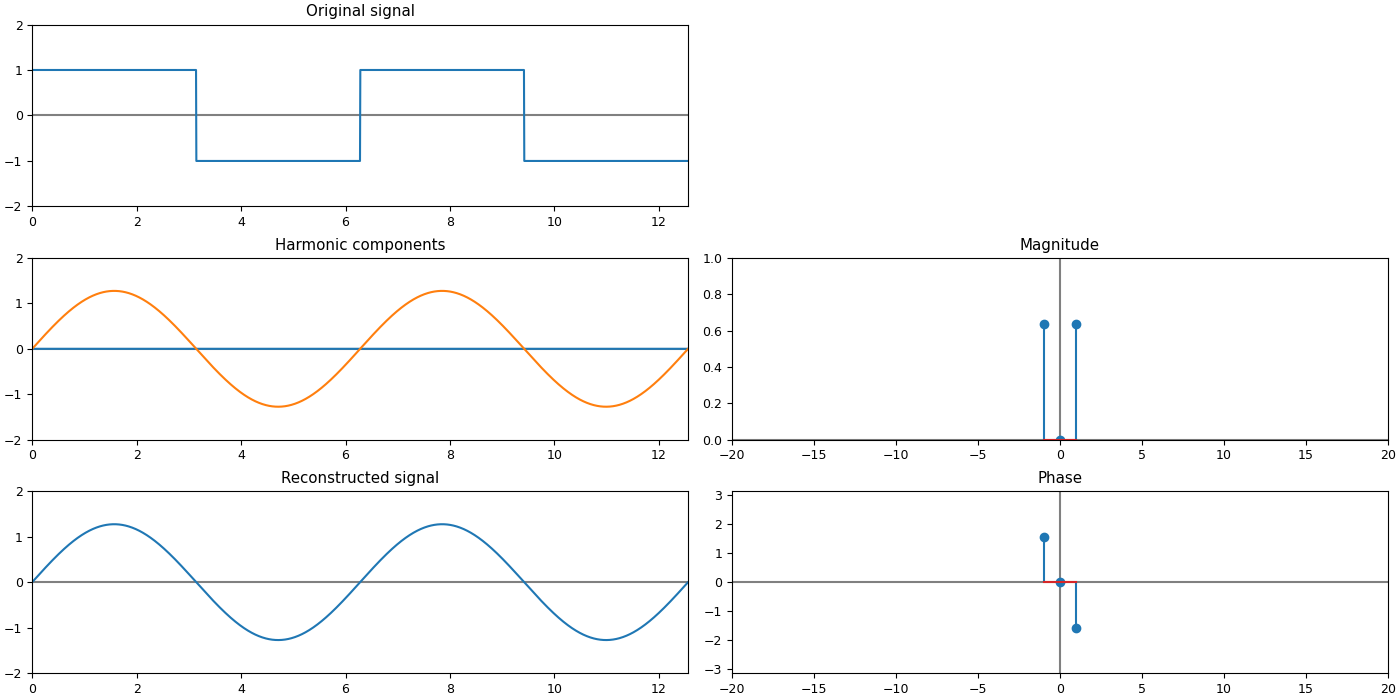

In [88]:
# Load modules for intereactive operation
%matplotlib ipympl
import ipywidgets as widgets   # Widgets for interactive operation

#  Function that runs the demo interactively
def run_demo(n_coeff, waveform, phase, offset):
    """Set values and call plotting function."""
    signal.waveform = waveform
    signal.phase = phase
    signal.offset = offset
    signal.n_coeff = n_coeff+1
    signal.plot()
    return

# Define signal and run demo
signal = FourierSynthesis()

# Define and display widgets
title_widget = widgets.Label("Fourier Synthesis", 
                             style=dict(font_weight='bold'))

widget_style = dict(description_width='initial')

n_coeff_widget = widgets.IntSlider(min=0, max= 30, value=1, step=1, 
                                       description='No. of coefficients',  
                                       readout_format='d', 
                                       layout=widgets.Layout(width='90%'), 
                                       style=widget_style)

waveform_widget = widgets.Dropdown(options=['Square', 'Triangle', 'Sawtooth', 'Cosine'],
                                   value='Square',
                                   description='Waveform type',
                                   layout=widgets.Layout(width='20%'), 
                                   style=widget_style)

phase_widget = widgets.FloatText(min=-180, max= 180, value=0, step=5, 
                                 description='Phase [deg]',  
                                 readout_format='.0f',
                                 layout=widgets.Layout(width='10%'), 
                                 style=widget_style)

offset_widget = widgets.FloatText(min=-1, max=1, value=0, step=0.1, 
                                 description='Offset',  
                                 readout_format='.1f',
                                 layout=widgets.Layout(width='10%'), 
                                 style=widget_style)

widget_line = widgets.HBox([waveform_widget, phase_widget, offset_widget], layout=widgets.Layout(width='100%'))

display(title_widget)
display(widget_line)
display(n_coeff_widget)

# Run demo from widgets
w = widgets.interactive(run_demo, n_coeff=n_coeff_widget, waveform=waveform_widget, phase=phase_widget, offset=offset_widget)